
# Toy example: Piecewise linear function

## Testing the Neural Incremental Posterior Estimation

#### Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
from utils import helpers
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

In [3]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C


import utils
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

- piecewise_linear is taking 6 parameters (changing points and slopes) and outputs a three-part piecewise linear function

- piecewise_linear_seq is taking a list of either 2, 3 or 4 parameters and then outputs either a one-part. a two-part or a three-part piecewise linear function

In [4]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_seq(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    add_noise=0.2
    
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    
    if (len(thetas)==2):
        a1 = thetas[0]
        b = thetas[1]
        
        if not add_noise == None:
            a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)  
            
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
        
        return y[x<cp1]
    
     
    if (len(thetas)==3):     
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        
        if not add_noise == None:
            a1,b, a2 = np.array([a1,b, a2]) + scp.random.normal(scale=add_noise,size=3)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
        
        return y[x<cp2]
    
    
    if (len(thetas)==4):
        
        
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        a3 = thetas[3]
        
        if not add_noise == None:
            a1,b, a2, a3 = np.array([a1,b, a2, a3]) + scp.random.normal(scale=add_noise,size=4)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
        # third piece
        y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
        
        return y

    
  

### Define prior and summary stats dependent on prior

In [5]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



## **Summary statistics**

definition of summary statistics for the piecewise linear function

In [194]:
"""
Summary stats
"""

def extract_sumstats(y):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    
    max_time = 10
    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        #print(len(batch))
        
        #print(batch)
        
        step_size = max_time/len(batch)
        
        
        x = torch.arange(0, max_time, step_size, dtype=torch.float64)
        
        
        
        
        batch[x>max_time] = np.nan
        s = []
        
        s.append(np.float32(batch[0]))    #offset
        s.append(np.nanmin(batch[x<3]))   # local min
        s.append(np.nanmax(batch[x<3]))   # local min
        
        #print(type(s[0]), type(s[1]))
        s.append(np.nanargmin(batch[x<3]))   #value of min
        
        s.append(np.nanargmax(batch[x<3]))
        
        #s.append(np.mean(batch[(x<3)]))
    

        # second batch of sumstats for times > 4
        if len(batch) > 300 :
            s.append(np.nanmax(batch[(x>=3)&(x<6)]))
            s.append(np.nanmin(batch[(x>=3)&(x<6)]))
            s.append(np.nanargmin(batch[(x>=3)&(x<6)]))
            s.append(np.nanargmax(batch[(x>=3)&(x<6)]))

        # third batch of sumstats for times > 5
        if len(batch) > 600:
            s.append(np.nanmin(batch[x>=6]))
            s.append(np.nanargmin(batch[x>=6]))
            
            s.append(np.nanmax(batch[x>=6]))
            s.append(np.nanargmax(batch[x>=6]))
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    
    

## Sequential Time Series SBI


We have the following parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [195]:
#parameter a1,b,a2,a3, cp1, cp2


prior_min = [3, 3, -5, 0]  

prior_max = [7, 7, -1, 4]

num_simulations=300

In [196]:
import datetime

In [197]:
start = datetime.datetime.now()

In [198]:
true_params = [5, 5, -3, 2]

obs_real = piecewise_linear_seq(true_params)


obs_real_stats = extract_sumstats([obs_real])[0]

## First round

In [199]:
### first round:
from sbi import utils as utils

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])


#inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior1)
inf = SNPE_C(prior, density_estimator=density_estimator)


theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [200]:
x = extract_sumstats(x_without)

In [201]:
x.shape

torch.Size([300, 5])

In [202]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 90 epochs.


In [203]:
obs_real_stats

tensor([  5.3043,   5.3043,  20.7040,   0.0000, 299.0000,  20.7040,  11.7861,
        299.0000,   0.0000,  11.7861,   0.0000,  20.1270, 399.0000])

In [ ]:
num_samples = 1000

samples = posterior.sample((num_samples,), x=obs_real_stats[:x.shape[1]])

proposal1 = posterior.set_default_x(obs_real_stats[:x.shape[1]])

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance

acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance

acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance

acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [ ]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:3], high = prior_max[2:3])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined)

inf = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

In [ ]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

In [ ]:
posterior2 = inf.build_posterior(density_estimator)

In [ ]:
x.shape

In [ ]:

samples = posterior2.sample((num_samples,), x=obs_real_stats[:x.shape[1]])

proposal2 = posterior2.set_default_x(obs_real_stats[:x.shape[1]])

## Third and last round

In [ ]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=[prior_min[3]], high = [prior_max[3]])


prior_combined2 = Combined(proposal2, prior3, number_params_1=3)



density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior_combined2)

inf = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

In [ ]:
x = extract_sumstats(x_without)


print(x.shape)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

In [ ]:
x.shape

obs_real_stats

In [ ]:
finish = datetime.datetime.now()

time = finish - start

print(time)

In [ ]:



samples = posterior3.sample((1000,), x=obs_real_stats)

In [ ]:
prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)

In [ ]:
end = get_time()


print('start:', start, '\nend:', end)

In [ ]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples)


s_x_prior = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples_prior)

In [ ]:
s_x_stat = extract_sumstats(s_x)

s_x_prior_stat = extract_sumstats(s_x_prior)



In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


  

In [ ]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([5, 5, -3, 2])

parameter_names = ['a1', 'b', 'a2', 'a3']

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    upper = "kde",
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

### Validating summary statistics with histogram plots

We should see that posterior is restricting the area of values

10
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


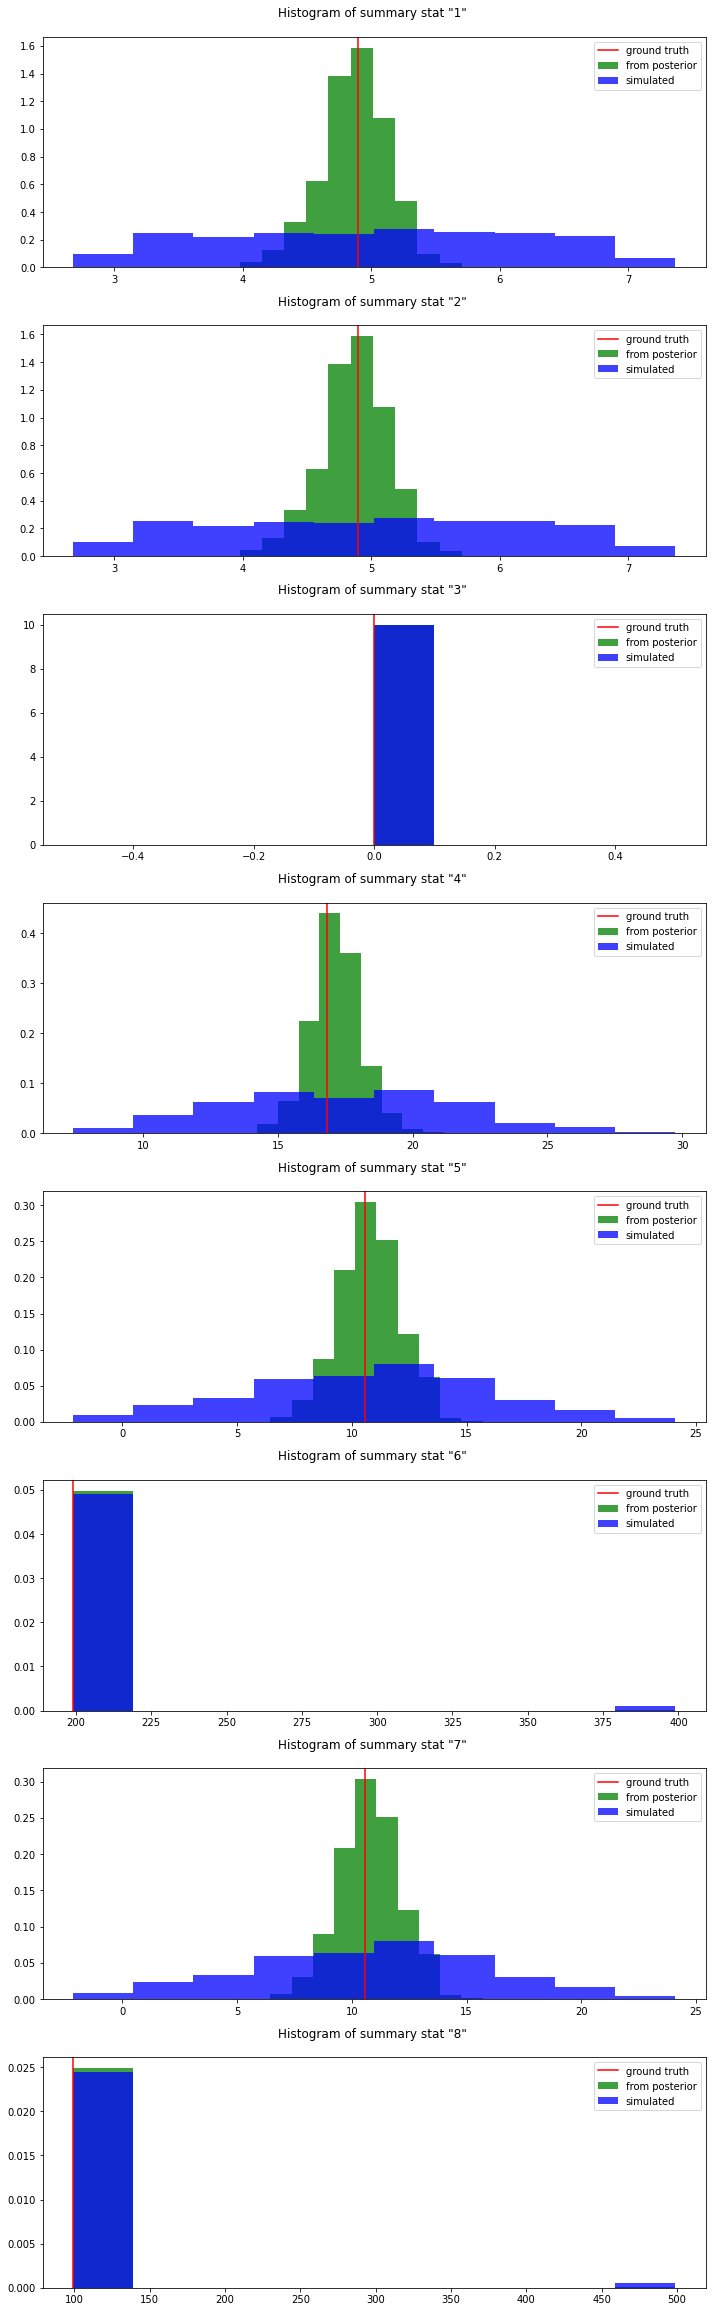

In [32]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)
print(len(s_x_stat[0]))

sum_stats_names = torch.arange(1, len(s_x_stat[0]), 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')